## 3D Datagenerator tests

In [1]:
# define logging and working directory
import os
import logging
import platform
import SimpleITK as sitk
import glob
import random
from collections import Counter
import matplotlib.pyplot as plt
import keras
from skimage.transform import resize
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

from ipywidgets import interact
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# setup working directory
print(os.getcwd())
# change working directory to project root - neccessary for jupyter notebooks
if platform.system() is "Windows":
    os.chdir('E:\\sven\\git\\cardio')
else:
    os.chdir('/Users/minority/Code/Git/cardio')
print(os.getcwd())


from src.utils.utils_io import Console_and_file_logger, ensure_dir
from src.utils.myshow import myshow, myshow3d
from src.visualization.visualize import plot_3d_vol, plot_4d_vol
from src.data.dataset import get_metadata_maybe, filter_4d_vol, describe_sitk
Console_and_file_logger('3d_DataGenerator_tests', logging.INFO)



2019-06-19 10:08:36,133 INFO -------------------- Start --------------------
2019-06-19 10:08:36,164 INFO Filename: 3d_DataGenerator_tests
2019-06-19 10:08:36,164 INFO Log directory: ./logs/


E:\sven\git\cardio\notebooks\dataset
E:\sven\git\cardio
Working directory: E:\sven\git\cardio.
Log dir: ./logs/


## Get all 3D image and mask files

In [2]:
def get_3d_img_msk_files(path):
    masks = sorted(glob.glob(os.path.join(path,'*msk.nrrd')))
    images = sorted(glob.glob(os.path.join(path, '*img.nrrd')))
    
    return images, masks

In [3]:
images_f, masks_f = get_3d_img_msk_files('data/raw/tetra/3D_export/')

## Visualize shape and masks

In [53]:
@interact
def plot_masks(path=masks_f):
    logging.info(path)
    sitk_img = sitk.ReadImage(path, sitk.sitkFloat32)
    describe_sitk(sitk_img)
    plot_3d_vol(sitk_img)

interactive(children=(Dropdown(description='path', options=('data/raw/tetra/3D_export\\0003-04NEJQUZ-2007-03-1…

## Visualize shape and masks with slider

In [5]:
@interact
def plot_masks(selected=(0, len(masks_f), 1)):
    path = masks_f[selected]
    logging.info(path)
    sitk_img = sitk.ReadImage(path, sitk.sitkFloat32)
    describe_sitk(sitk_img)
    plot_3d_vol(sitk_img)

interactive(children=(IntSlider(value=505, description='selected', max=1010), Output()), _dom_classes=('widget…

## Resample 3D image with reference image

In [54]:
# patient 0007 has a shape of 256 x 256 x 10
@interact
def resample_with_reference(reference_image=masks_f, target_image=reversed(masks_f)):

    # resample tests
    img_1 = reference_image
    logging.info('image: {} - base:'.format(img_1))
    sitk_img1 = sitk.ReadImage(img_1)
    sitk_img1.SetOrigin((0,0,0))
    describe_sitk(sitk_img1)
    plot_3d_vol(sitk_img1)
    plt.show()

    img_2 = target_image
    logging.info('image: {} before resample:'.format(img_2))
    sitk_img2 = sitk.ReadImage(img_2)
    sitk_img2.SetOrigin((0,0,0))
    describe_sitk(sitk_img2)
    plot_3d_vol(sitk_img2)
    plt.show()


    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(sitk_img1)
    resampled = resampler.Execute(sitk_img2)

    logging.info('image 2 after resample:')
    plot_3d_vol(resampled)
    describe_sitk(resampled)

interactive(children=(Dropdown(description='reference_image', options=('data/raw/tetra/3D_export\\0003-04NEJQU…

## Resample 3D image with fix values

In [55]:
w = h = ''
@interact
def resample_single_fixed(target_image=masks_f, size_x=(0,500,1), size_y=(0,500,1),size_z=(0,50,1),spacing_x=(0,2.5,0.05), spacing_y=(0,2.5,0.05),spacing_z=(0,16,0.1), resample=False):
    
    global w, h
    
    
    if resample:
        img_2 = target_image
        logging.info('image: {} before resample:'.format(img_2))
        sitk_img2 = sitk.ReadImage(img_2, sitk.sitkFloat32)
        describe_sitk(sitk_img2)
        plot_3d_vol(sitk_img2)
        plt.show()

        resampler = sitk.ResampleImageFilter()
        #resampler.SetSize((size_x, size_y, size_z))
        
        # keep size
        old_spacing = sitk_img2.GetSpacing()
        old_size = sitk_img2.GetSize()
        print(old_size)
        x_s = (old_size[0] * old_spacing[0])/spacing_x
        y_s = (old_size[1] * old_spacing[1])/spacing_y
        z_s = (old_size[2] * old_spacing[2])/spacing_z
        
        s = (int(x_s),int(y_s), int(z_s))
        resampler.SetSize(s)
        resampler.SetOutputSpacing((spacing_x, spacing_y, spacing_z))
        resampler.SetOutputOrigin(sitk_img2.GetOrigin())
        resampler.SetInterpolator(sitk.sitkNearestNeighbor)
        #resampler.SetInterpolator(sitk.sitkLinear)
        #resampler.SetOutputPixelType(sitk.sitkUInt16)
        resampled = resampler.Execute(sitk_img2)
        logging.info('image 2 after resample:')
        #myshow3d(resampled)
        #sitk.WriteImage(resampled, 'data/interim/resampled_3d_test.nrrd')
        plot_3d_vol(resampled)
        describe_sitk(resampled)
        plt.show()
        globals()['resampled'] = resampled
        resampled_nda = sitk.GetArrayFromImage(resampled)
        # center crop to square
        h, w = resampled_nda.shape[1:]

        if h != w:
            margin = (h - w)//2

        # crop width if width > height
            if margin > 0:
                resampled_nda = resampled_nda[:,margin:-margin,:]
            elif margin < 0:
                margin = -margin
                resampled_nda = resampled_nda[...,margin:-margin]
        
        
                    # resample
            sitk_msk_resampled = resample_3D(sitk_img=sitk_msk, size=(self.dim[2],self.dim[1],self.dim[0]), spacing=(self.spacing[0],self.spacing[1],self.spacing[2]), interpolate=sitk.sitkNearestNeighbor)
            if logging.getLogger().isEnabledFor(logging.DEBUG):
                logging.info('mask resampled:')
                describe_sitk(sitk_msk_resampled)
                plot_3d_vol(sitk_msk_resampled)

            # transform the labels to binary channel masks
            mask_nda = sitk.GetArrayFromImage(sitk_msk_resampled)
            mask_nda = mask_nda[..., np.newaxis]
            mask = np.zeros((y.shape[1:]), dtype=np.bool)
            for ix, mask_value in enumerate(self.mask_values):
                mask[..., ix] = np.maximum(mask, mask_nda == mask_value)[..., ix]
            if logging.getLogger().isEnabledFor(logging.DEBUG):
                logging.info('mask with channels:')
                describe_sitk(mask)
                plot_3d_vol(mask)
        
        """
                def crop_z_center(img, size_z):
            
            z, x,y = img.shape
            print(z)
            
            if z > size_z:
                diff = z - size_z
                diff = diff//2
                img = img[diff:-diff,...]
            assert(img.shape[1]==size_z)
            return img

                
        # center crop z axis to
        resampled_nda = crop_z_center(resampled_nda, size_z)
        """

                
        plot_3d_vol(resampled_nda)
        describe_sitk(resampled_nda)
        

interactive(children=(Dropdown(description='target_image', options=('data/raw/tetra/3D_export\\0003-04NEJQUZ-2…

In [4]:
# Define the loglevel
logging.getLogger().setLevel(logging.DEBUG)
mpl_logger = logging.getLogger('matplotlib') 
mpl_logger.setLevel(logging.WARNING) 

w = h = ''
@interact
def resample_single_fixed_interact(target_mask=masks_f, size_x=(0,500,1), size_y=(0,500,1),size_z=(0,50,1),spacing_x=(0,2.5,0.05), spacing_y=(0,2.5,0.05),spacing_z=(0,16,0.1), resample=False):
    
    global w, h
    
    logging.info('image: {} before resample:'.format(target_mask))


    # load, preprocess image
    img_sitk = sitk.ReadImage(target_mask.replace('msk', 'img'), sitk.sitkFloat32)

    # load, preprocess mask
    mask_sitk = sitk.ReadImage(target_mask, sitk.sitkFloat32)

    # transform to nda
    img_nda = sitk.GetArrayFromImage(img_sitk)
    # transform to nda
    mask_nda = sitk.GetArrayFromImage(mask_sitk)
    
    logging.debug('raw:')
    describe_sitk(img_sitk)
    describe_sitk(mask_sitk)

    if resample:
        
        if logging.getLogger().isEnabledFor(logging.DEBUG):

            plot_4d_vol(np.stack([img_nda, mask_nda], axis=0))
            plt.show()
    
        # resample image
        resampler = sitk.ResampleImageFilter()
        
        # get current spacing and shape
        old_spacing = img_sitk.GetSpacing()
        old_size = img_sitk.GetSize()
        
        # calc new shape with given spacing
        new_x_s = (old_size[0] * old_spacing[0])/spacing_x
        new_y_s = (old_size[1] * old_spacing[1])/spacing_y
        new_z_s = (old_size[2] * old_spacing[2])/spacing_z
        s = (int(new_x_s),int(new_y_s), size_z)
        resampler.SetSize(s)
        resampler.SetOutputSpacing((spacing_x, spacing_y, spacing_z))
        resampler.SetOutputOrigin(img_sitk.GetOrigin())
        resampler.SetInterpolator(sitk.sitkLinear)
        img_resampled = resampler.Execute(img_sitk)
        
        # change interpolation for masks
        resampler.SetInterpolator(sitk.sitkNearestNeighbor)
        mask_resampled = resampler.Execute(mask_sitk)
        
        # transform to nda
        img_nda = sitk.GetArrayFromImage(img_resampled)
        # transform to nda
        mask_nda = sitk.GetArrayFromImage(mask_resampled)
        
        if logging.getLogger().isEnabledFor(logging.DEBUG):
            logging.debug('resampled image:')
            describe_sitk(img_resampled)
            describe_sitk(mask_resampled)
            plot_4d_vol(np.stack([img_nda, mask_nda], axis=0))
            plt.show()
            
            
        # center crop image/mask to square
        h, w = img_nda.shape[-2:] # numpy shape has different order than sitk
        logging.info('shape: {}'.format(img_nda.shape))
        if h != w:
            margin = (h - w)//2

        # crop width if width > height
            if margin > 0: # height is bigger than width, crop height
                logging.info('margin: {}'.format(margin))
                img_nda = img_nda[:,margin:-margin,:]
                mask_nda = mask_nda[:,margin:-margin,:]
            elif margin < 0: # width is bigger than height, crop width
                margin = -margin
                img_nda = img_nda[...,margin:-margin]
                mask_nda = mask_nda[...,margin:-margin]
                
        if logging.getLogger().isEnabledFor(logging.DEBUG):
            logging.info('cropped:')
            describe_sitk(img_nda)
            describe_sitk(mask_nda)
            plot_4d_vol(np.stack([img_nda, mask_nda], axis=0))
            plt.show()
            
        def crop_center(img,cropx,cropy):
            y,x = img.shape[-2:]
            startx = x//2-(cropx//2)
            starty = y//2-(cropy//2)    
            return img[:,starty:starty+cropy,startx:startx+cropx]
        
        # center crop to given size, check if bigger or smaller
        if img_nda.shape[2] > size_x:
            img_nda = crop_center(img_nda, size_x, size_y)
            mask_nda = crop_center(mask_nda, size_x, size_y)
        else:
            logging.error('image too small, need to resize slice wise')
            # resize
            imgs = []
            for img in img_nda:
                imgs.append(resize(img, self.dim[1:], mode='constant', preserve_range=True, anti_aliasing=True, clip=False))
            img_nda = np.stack(imgs, axis=0)
            # resize
            masks = []
            for mask in mask_nda:
                masks.append(resize(mask, self.dim[1:], mode='constant', anti_aliasing=True, preserve_range=True,order=0, cval=0, clip=False).astype(mask_nda.dtype))
            mask_nda = np.stack(masks, axis=0)
            
        if logging.getLogger().isEnabledFor(logging.DEBUG):
            logging.info('center cropped:')
            describe_sitk(img_nda)
            describe_sitk(mask_nda)
            plot_4d_vol(np.stack([img_nda, mask_nda], axis=0))
            plt.show()
            
        # clip to values between 0 and .999 quantile
        ninenine_q = np.quantile(img_nda.flatten(), .999, overwrite_input=False)
        img_nda = np.clip(img_nda, 0, ninenine_q)
        
        if logging.getLogger().isEnabledFor(logging.DEBUG):
            logging.info('.999 quantile value clipping:')
            describe_sitk(img_nda)
            describe_sitk(mask_nda)
            plot_4d_vol(np.stack([img_nda, mask_nda], axis=0))
            plt.show()

        # normalize to values between 0 and 1
        img_nda = (img_nda -img_nda.min() ) / (img_nda.max() - img_nda.min())
        
        if logging.getLogger().isEnabledFor(logging.DEBUG):
            logging.info('clipped and normalized image:')
            describe_sitk(img_nda)
            describe_sitk(mask_nda)
            plot_4d_vol(np.stack([img_nda, mask_nda], axis=0))
            plt.show()
            
        # transform the labels to binary channel masks
        mask = np.zeros((*mask_nda.shape,4), dtype=np.bool)
        for ix, mask_value in enumerate(np.unique(mask_nda)):
            mask[..., ix] = np.maximum(mask[...,ix], mask_nda == mask_value)
            
        mask_nda = mask

        if logging.getLogger().isEnabledFor(logging.DEBUG):
            logging.info('with channels:')
            describe_sitk(img_nda)
            describe_sitk(mask_nda)
            plt.show()


        

interactive(children=(Dropdown(description='target_mask', options=('data/raw/tetra/3D_export\\0003-04NEJQUZ-20…

## Resample a bunch of images with fixed values

In [60]:
@interact
def resample_multi_fixed(start_image=(0,len(masks_f),1), size_x=(0,512,1), size_y=(0,512,1),size_z=(0,24,1),spacing_x=(0,2.5,0.05), spacing_y=(0,2.5,0.05),spacing_z=(0,20,0.1), images=(1,20,1), resample=False):

    if resample:
        for i in range (images):
            img_2 = masks_f[start_image + i]
            logging.info('image: {} before resample:'.format(img_2))
            sitk_img2 = sitk.ReadImage(img_2)
            describe_sitk(sitk_img2)
            plot_3d_vol(sitk_img2)

            resampler = sitk.ResampleImageFilter()
            resampler.SetSize((size_x, size_y, size_z))
            resampler.SetOutputSpacing((spacing_x, spacing_y, spacing_z))
            resampler.SetOutputOrigin(sitk_img2.GetOrigin())
            resampler.SetInterpolator(sitk.sitkNearestNeighbor)
            resampled = resampler.Execute(sitk_img2)

            logging.info('image: {} after resample:'.format(img_2))
            describe_sitk(resampled)
            plot_3d_vol(resampled)
            plt.show()
            

interactive(children=(IntSlider(value=505, description='start_image', max=1010), IntSlider(value=256, descript…

## Initialize a DataGenerator and plot x and y

In [57]:
from src.data.preprocess import resample_3D
from src.visualization.visualize import show_slice, show_slice_transparent, plot_3d_vol
from src.data.generators import DataGenerator3D

2019-06-16 12:45:00,964 INFO Create DataGenerator
2019-06-16 12:45:00,964 INFO No augmentation
2019-06-16 12:45:01,143 DEBUG raw:
2019-06-16 12:45:01,146 INFO size: (256, 256, 18)
2019-06-16 12:45:01,147 INFO spacing: (1.40625, 1.40625, 6.59999990463256)
2019-06-16 12:45:01,149 INFO origin: (127.947171092033, -219.53451389074, 139.359773010015)
2019-06-16 12:45:01,150 INFO direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
2019-06-16 12:45:01,152 INFO pixel type: 32-bit float
2019-06-16 12:45:01,153 INFO number of pixel components: 1
2019-06-16 12:45:01,155 INFO size: (256, 256, 18)
2019-06-16 12:45:01,157 INFO spacing: (1.40625, 1.40625, 6.59999990463256)
2019-06-16 12:45:01,158 INFO origin: (127.947171092033, -219.53451389074, 139.359773010015)
2019-06-16 12:45:01,160 INFO direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
2019-06-16 12:45:01,162 INFO pixel type: 32-bit float
2019-06-16 12:45:01,163 INFO number of pixel components: 1
2019-06-16 12:45:01,171 INFO No timest

[0, 1]


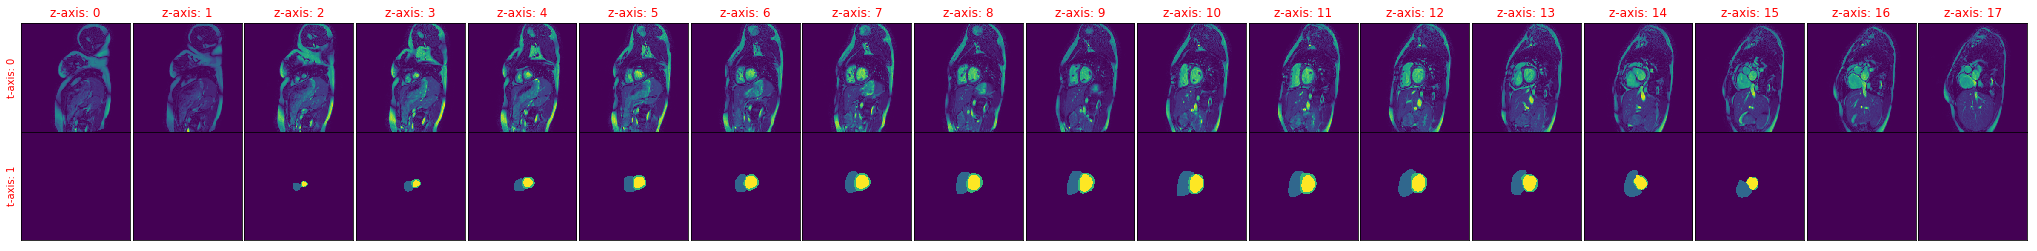

2019-06-16 12:45:03,516 DEBUG resampled image:
2019-06-16 12:45:03,518 INFO size: (288, 288, 12)
2019-06-16 12:45:03,519 INFO spacing: (1.25, 1.25, 10.0)
2019-06-16 12:45:03,520 INFO origin: (127.947171092033, -219.53451389074, 139.359773010015)
2019-06-16 12:45:03,521 INFO direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
2019-06-16 12:45:03,522 INFO pixel type: 32-bit float
2019-06-16 12:45:03,523 INFO number of pixel components: 1
2019-06-16 12:45:03,524 INFO size: (288, 288, 12)
2019-06-16 12:45:03,525 INFO spacing: (1.25, 1.25, 10.0)
2019-06-16 12:45:03,525 INFO origin: (127.947171092033, -219.53451389074, 139.359773010015)
2019-06-16 12:45:03,526 INFO direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
2019-06-16 12:45:03,527 INFO pixel type: 32-bit float
2019-06-16 12:45:03,528 INFO number of pixel components: 1
2019-06-16 12:45:03,533 INFO No timesteps given for: temp/, use img.shape[0]


[0, 1]


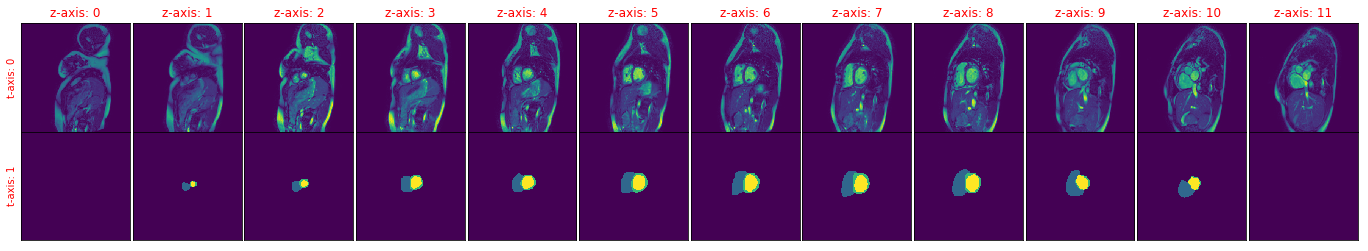

2019-06-16 12:45:04,844 DEBUG shape: (12, 288, 288)
2019-06-16 12:45:04,844 DEBUG cropped:
2019-06-16 12:45:04,890 INFO size: (288, 288, 12)
2019-06-16 12:45:04,890 INFO spacing: (1.0, 1.0, 1.0)
2019-06-16 12:45:04,890 INFO origin: (0.0, 0.0, 0.0)
2019-06-16 12:45:04,890 INFO direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
2019-06-16 12:45:04,890 INFO pixel type: 32-bit float
2019-06-16 12:45:04,890 INFO number of pixel components: 1
2019-06-16 12:45:04,906 INFO size: (288, 288, 12)
2019-06-16 12:45:04,906 INFO spacing: (1.0, 1.0, 1.0)
2019-06-16 12:45:04,922 INFO origin: (0.0, 0.0, 0.0)
2019-06-16 12:45:04,922 INFO direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
2019-06-16 12:45:04,922 INFO pixel type: 32-bit float
2019-06-16 12:45:04,922 INFO number of pixel components: 1
2019-06-16 12:45:04,922 INFO No timesteps given for: temp/, use img.shape[0]


[0, 1]


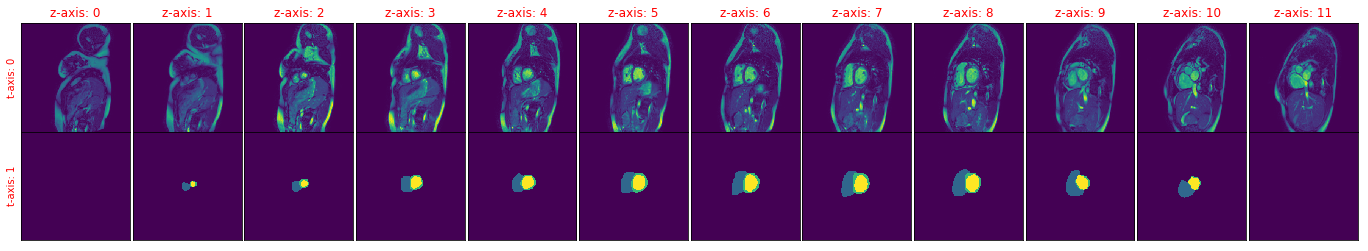

2019-06-16 12:45:06,310 DEBUG center cropped:
2019-06-16 12:45:06,326 INFO size: (256, 256, 12)
2019-06-16 12:45:06,326 INFO spacing: (1.0, 1.0, 1.0)
2019-06-16 12:45:06,326 INFO origin: (0.0, 0.0, 0.0)
2019-06-16 12:45:06,326 INFO direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
2019-06-16 12:45:06,326 INFO pixel type: 32-bit float
2019-06-16 12:45:06,326 INFO number of pixel components: 1
2019-06-16 12:45:06,326 INFO size: (256, 256, 12)
2019-06-16 12:45:06,341 INFO spacing: (1.0, 1.0, 1.0)
2019-06-16 12:45:06,341 INFO origin: (0.0, 0.0, 0.0)
2019-06-16 12:45:06,341 INFO direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
2019-06-16 12:45:06,341 INFO pixel type: 32-bit float
2019-06-16 12:45:06,341 INFO number of pixel components: 1
2019-06-16 12:45:06,341 INFO No timesteps given for: temp/, use img.shape[0]


[0, 1]


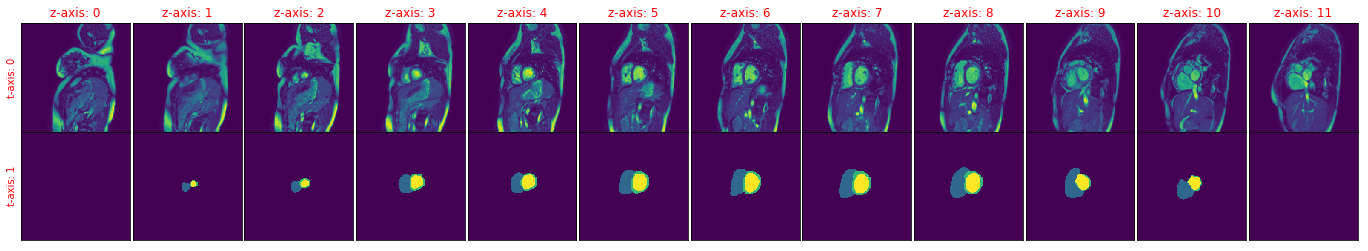

2019-06-16 12:45:07,745 DEBUG .999 quantile value clipping:
2019-06-16 12:45:07,761 INFO size: (256, 256, 12)
2019-06-16 12:45:07,761 INFO spacing: (1.0, 1.0, 1.0)
2019-06-16 12:45:07,761 INFO origin: (0.0, 0.0, 0.0)
2019-06-16 12:45:07,761 INFO direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
2019-06-16 12:45:07,761 INFO pixel type: 32-bit float
2019-06-16 12:45:07,761 INFO number of pixel components: 1
2019-06-16 12:45:07,777 INFO size: (256, 256, 12)
2019-06-16 12:45:07,777 INFO spacing: (1.0, 1.0, 1.0)
2019-06-16 12:45:07,777 INFO origin: (0.0, 0.0, 0.0)
2019-06-16 12:45:07,777 INFO direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
2019-06-16 12:45:07,777 INFO pixel type: 32-bit float
2019-06-16 12:45:07,777 INFO number of pixel components: 1
2019-06-16 12:45:07,777 INFO No timesteps given for: temp/, use img.shape[0]


[0, 1]


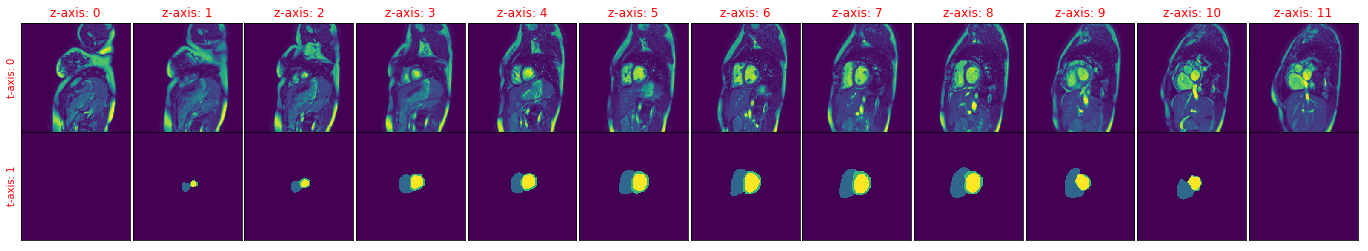

2019-06-16 12:45:09,243 DEBUG clipped and normalized image:
2019-06-16 12:45:09,243 INFO size: (256, 256, 12)
2019-06-16 12:45:09,243 INFO spacing: (1.0, 1.0, 1.0)
2019-06-16 12:45:09,259 INFO origin: (0.0, 0.0, 0.0)
2019-06-16 12:45:09,259 INFO direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
2019-06-16 12:45:09,259 INFO pixel type: 32-bit float
2019-06-16 12:45:09,259 INFO number of pixel components: 1
2019-06-16 12:45:09,274 INFO size: (256, 256, 12)
2019-06-16 12:45:09,274 INFO spacing: (1.0, 1.0, 1.0)
2019-06-16 12:45:09,274 INFO origin: (0.0, 0.0, 0.0)
2019-06-16 12:45:09,274 INFO direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
2019-06-16 12:45:09,274 INFO pixel type: 32-bit float
2019-06-16 12:45:09,274 INFO number of pixel components: 1
2019-06-16 12:45:09,274 INFO No timesteps given for: temp/, use img.shape[0]


[0, 1]


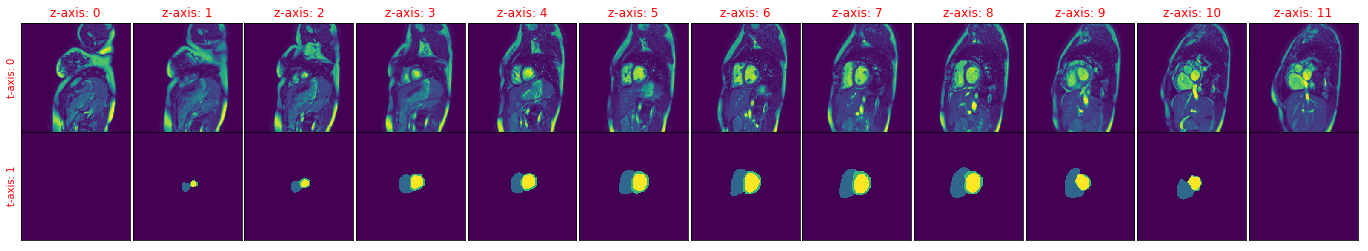

2019-06-16 12:45:10,850 DEBUG with channels:
2019-06-16 12:45:10,928 INFO size: (256, 256, 12)
2019-06-16 12:45:10,928 INFO spacing: (1.0, 1.0, 1.0)
2019-06-16 12:45:10,928 INFO origin: (0.0, 0.0, 0.0)
2019-06-16 12:45:10,928 INFO direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
2019-06-16 12:45:10,928 INFO pixel type: 32-bit float
2019-06-16 12:45:10,943 INFO number of pixel components: 1
2019-06-16 12:45:10,990 INFO size: (256, 256, 12)
2019-06-16 12:45:10,990 INFO spacing: (1.0, 1.0, 1.0)
2019-06-16 12:45:10,990 INFO origin: (0.0, 0.0, 0.0)
2019-06-16 12:45:10,990 INFO direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
2019-06-16 12:45:10,990 INFO pixel type: vector of 32-bit float
2019-06-16 12:45:10,990 INFO number of pixel components: 4
2019-06-16 12:45:11,021 INFO X shape: (1, 12, 256, 256, 1)
2019-06-16 12:45:11,021 INFO Y shape: (1, 12, 256, 256, 4)
2019-06-16 12:45:11,037 DEBUG timestep: 0 - plotting


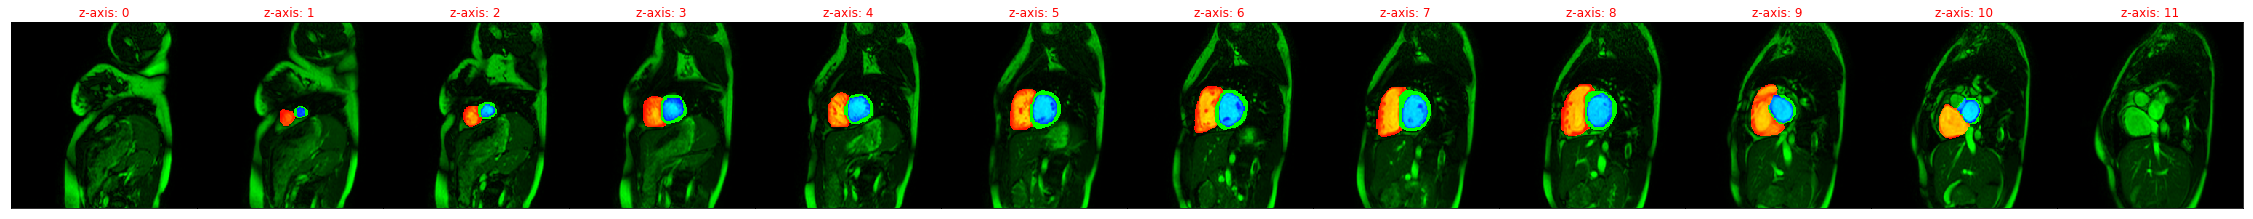

In [60]:
# create one Datagenerator and visualize one batch
logging.getLogger().setLevel(logging.DEBUG)
mpl_logger = logging.getLogger('matplotlib') 
mpl_logger.setLevel(logging.WARNING) 

batch_generator = DataGenerator3D(images_f, masks_f)
x, y = batch_generator.__getitem__(1)
logging.info('X shape: {}'.format(x.shape))
logging.info('Y shape: {}'.format(y.shape))
# plot x and y
plot_3d_vol(x[0], y[0],fig_size=(40,20))

In [ ]:
# 

# compare different overlay techniques

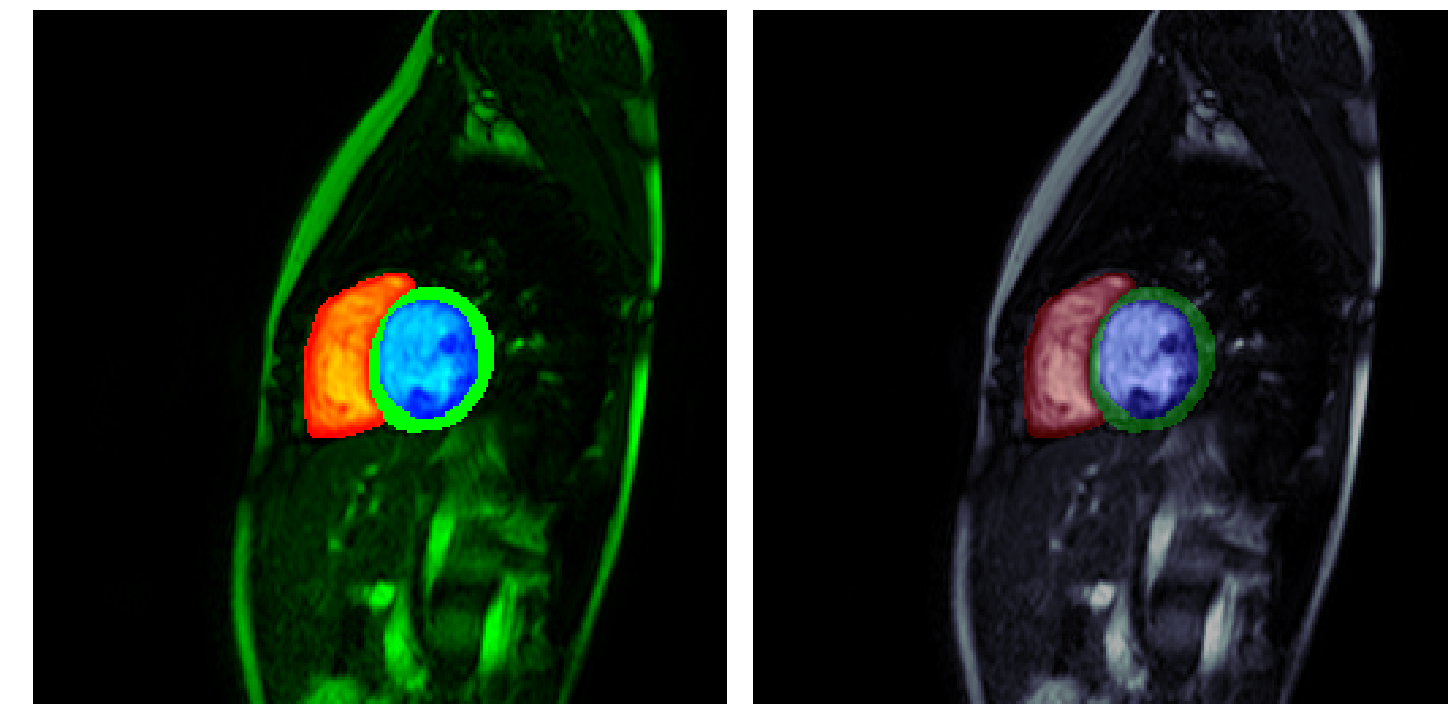

In [338]:
# overlay with alpha is only possible for plotting
from src.visualization.visualize import show_slice
mask = y[0][5]
im = x[0][5]

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(show_slice(im,mask, show=False))
ax1.axis('off')

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(im, 'bone')
ax2.imshow((mask[...,1:]).astype(np.float32), interpolation='none', alpha=.3)
ax2.axis('off')
fig.tight_layout(pad=0)


## compare show slice and show_slice_transparent

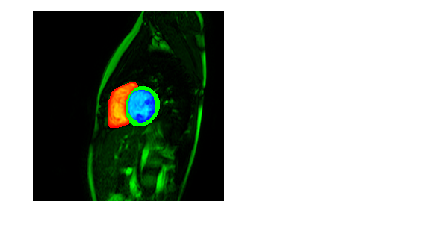

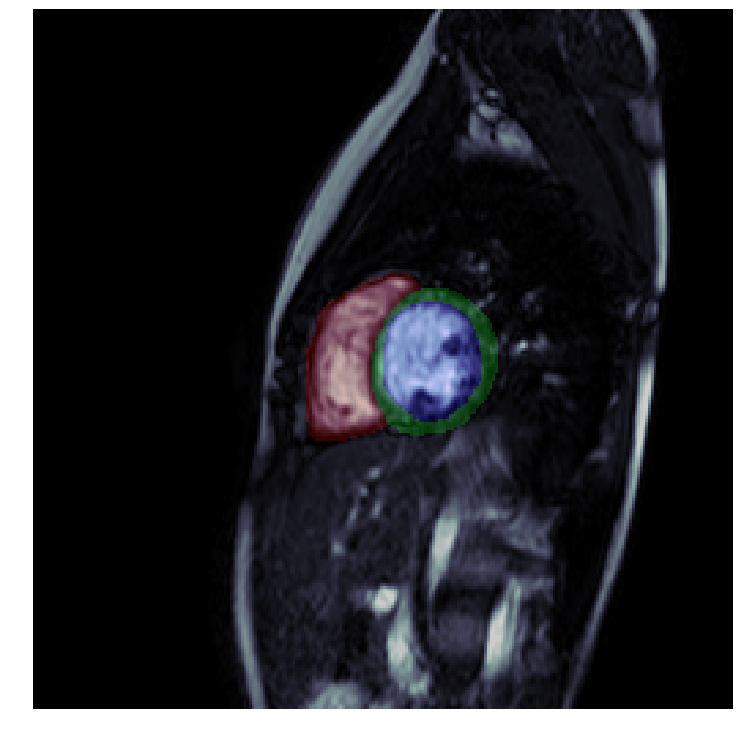

In [339]:
mask = y[0][5]
im = x[0][5]

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(show_slice(im,mask, show=False, f_size=(10,10)))
ax1.axis('off')
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(show_slice_transparent(im,mask, show=False, f_size=(10,10)))
ax2.axis('off')
fig.tight_layout(pad=0)


2019-04-13 19:57:56,109 INFO Image-shape: (256, 256)
2019-04-13 19:57:56,110 INFO Image data points: 55164
2019-04-13 19:57:56,111 INFO Image mean: 0.102
2019-04-13 19:57:56,112 INFO Image max: 1.000
2019-04-13 19:57:56,113 INFO Image min: 0.000
2019-04-13 19:57:56,115 INFO Mask-shape: (256, 256, 3)
2019-04-13 19:57:56,116 INFO RV mask data points: 1469
2019-04-13 19:57:56,118 INFO Myo mask data points: 689
2019-04-13 19:57:56,119 INFO LV mask data points: 1272
2019-04-13 19:57:56,121 INFO LV mask data points: 1272
2019-04-13 19:57:56,123 INFO RV mask mean: 0.0224151611328125
2019-04-13 19:57:56,124 INFO Myo mask mean: 0.0105133056640625
2019-04-13 19:57:56,125 INFO LV mask mean: 0.0194091796875


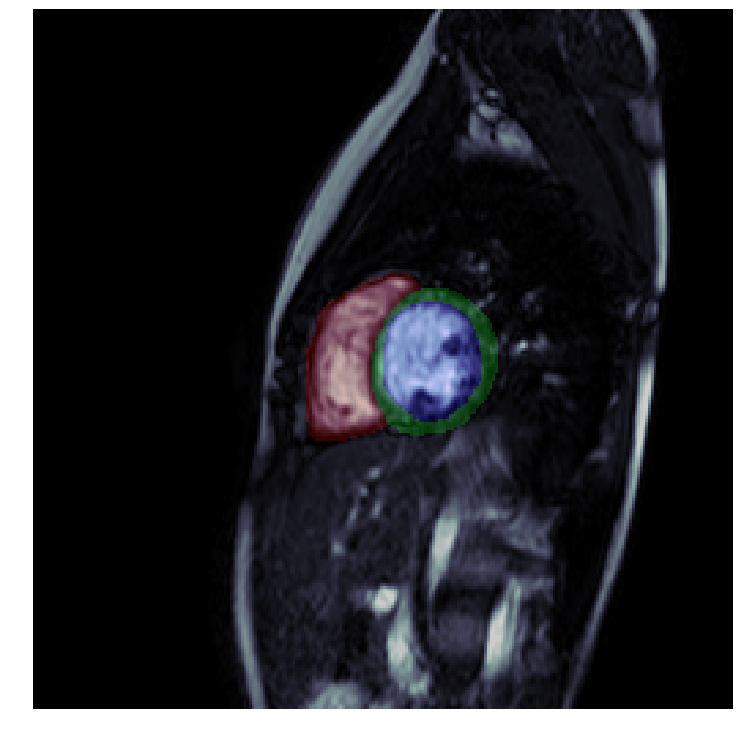

In [342]:
show_slice_transparent(im,mask, show=True, f_size=(10,10))

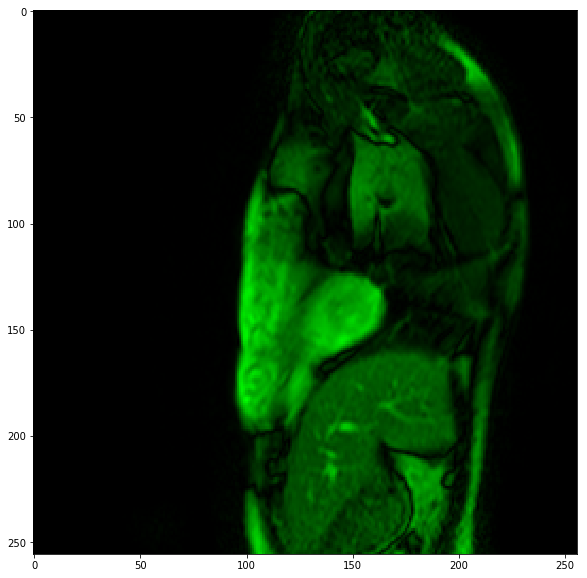

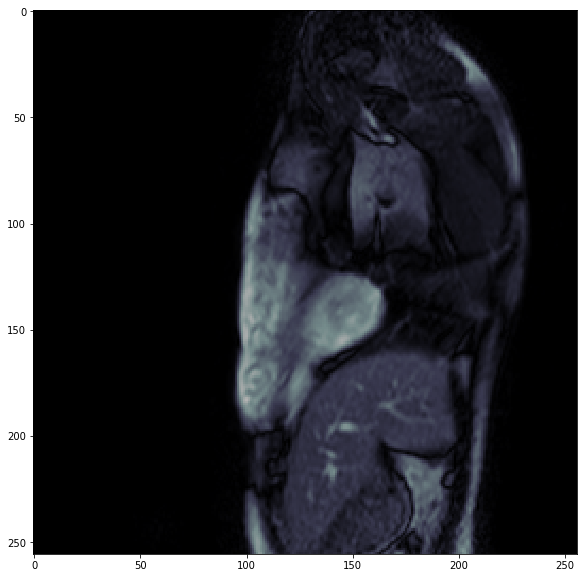

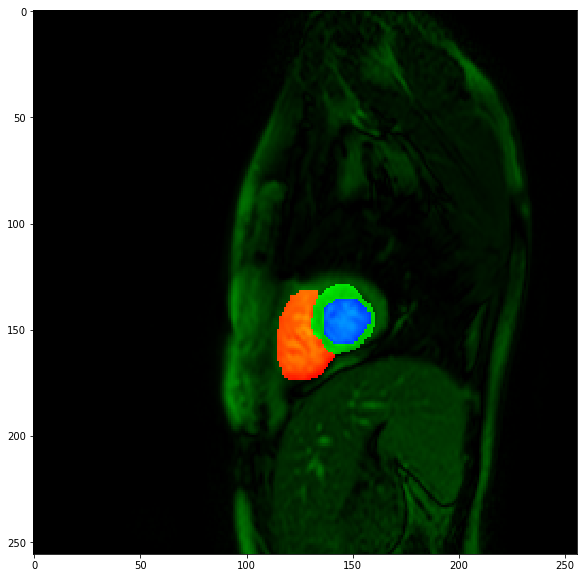

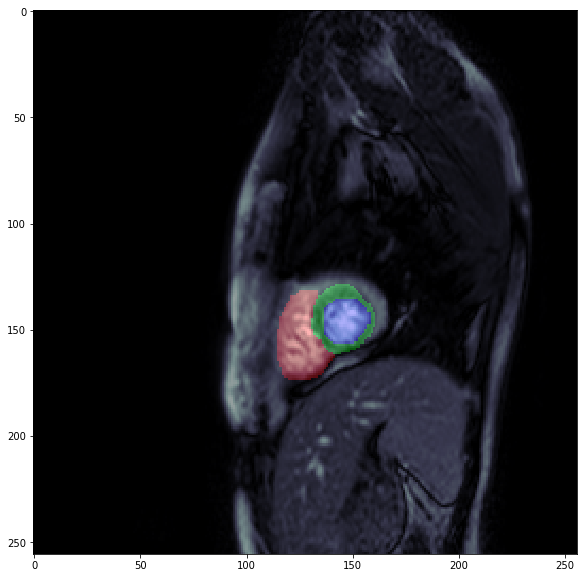

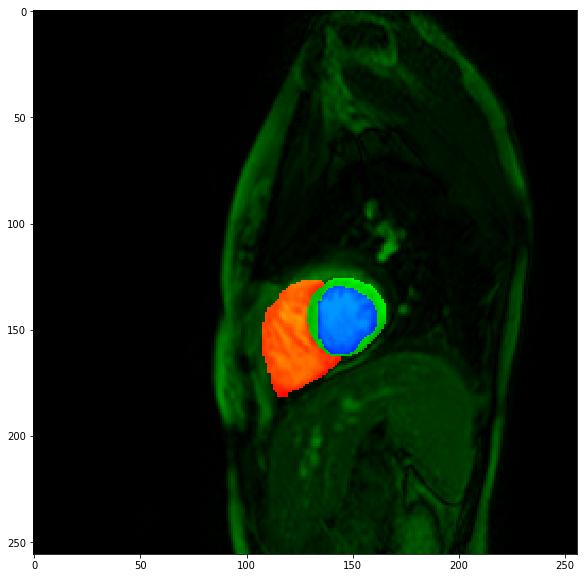

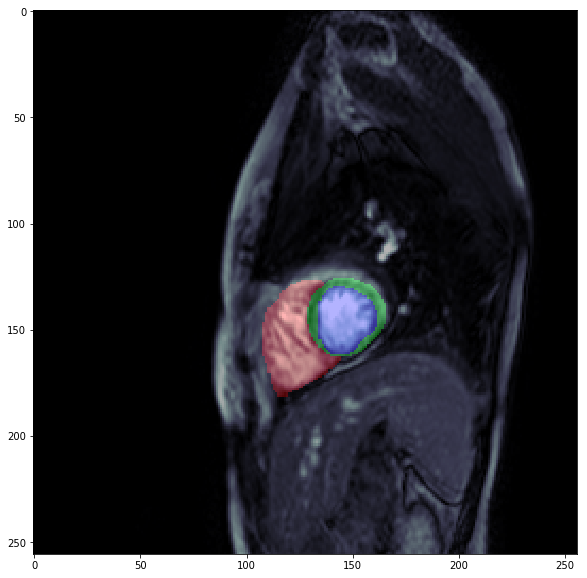

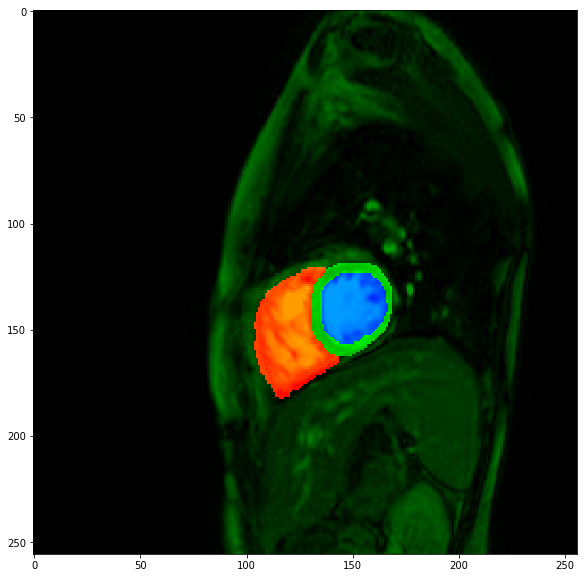

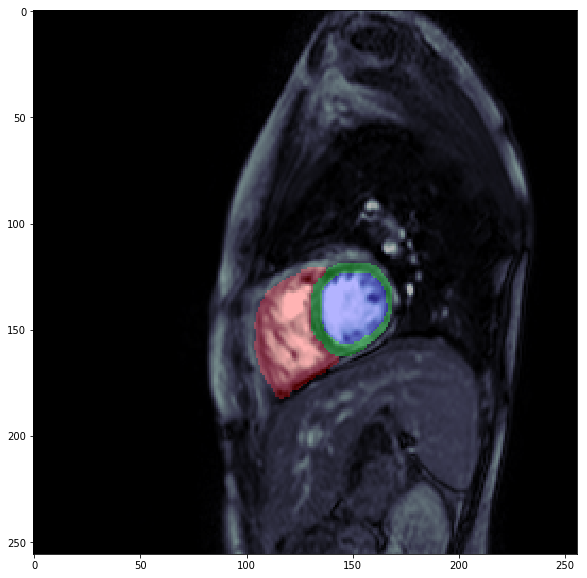

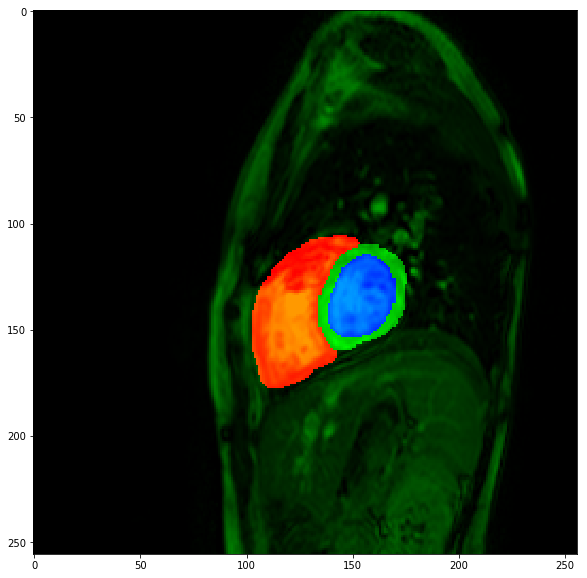

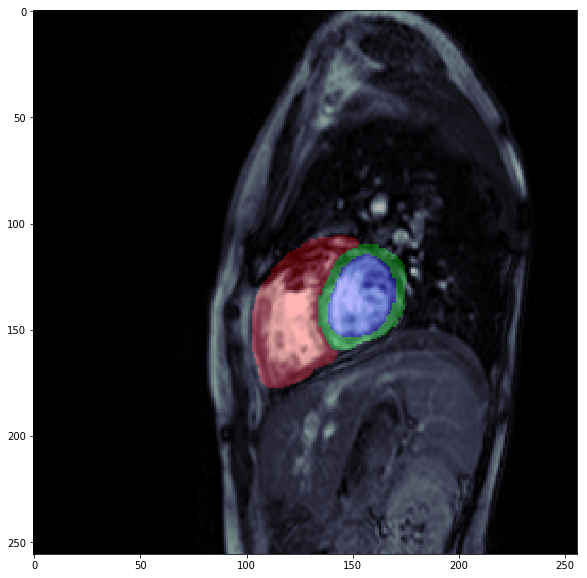

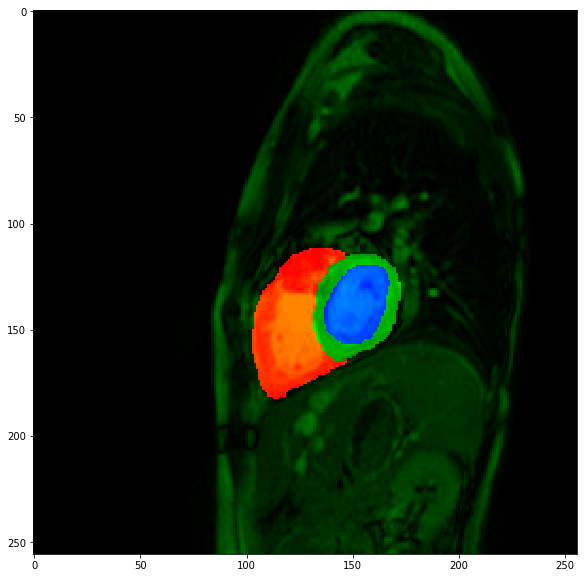

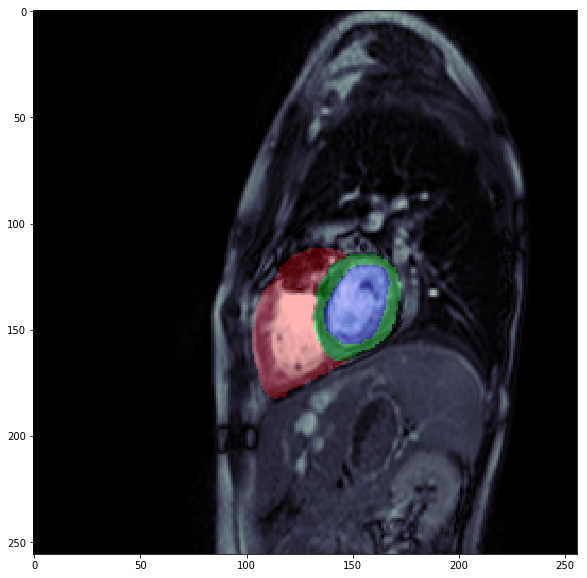

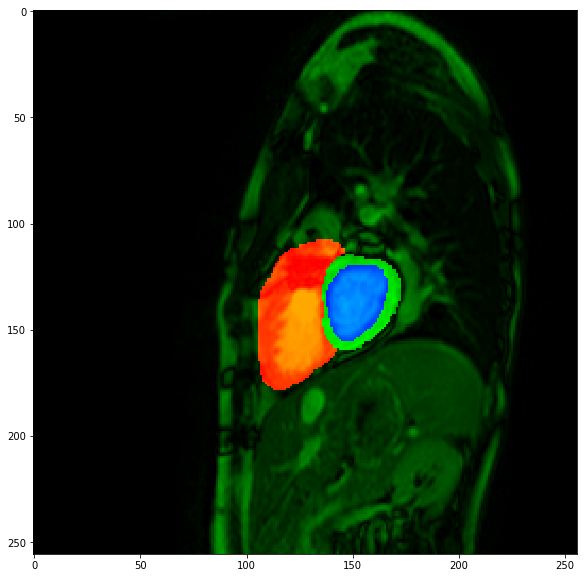

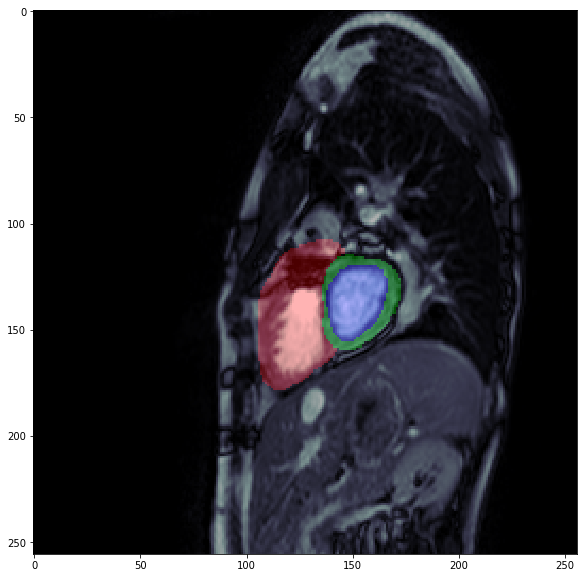

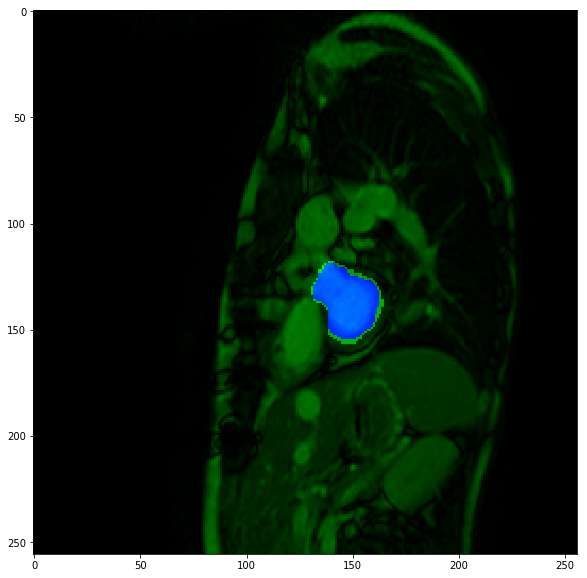

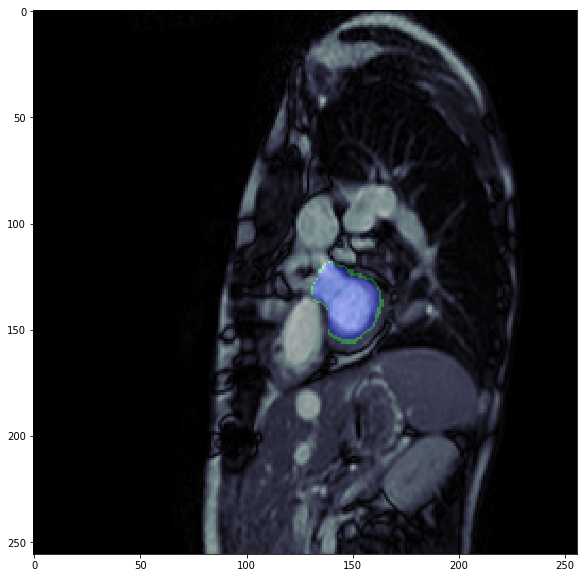

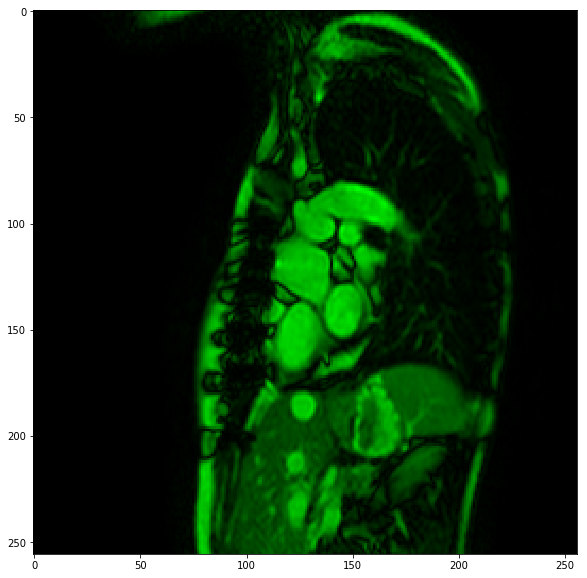

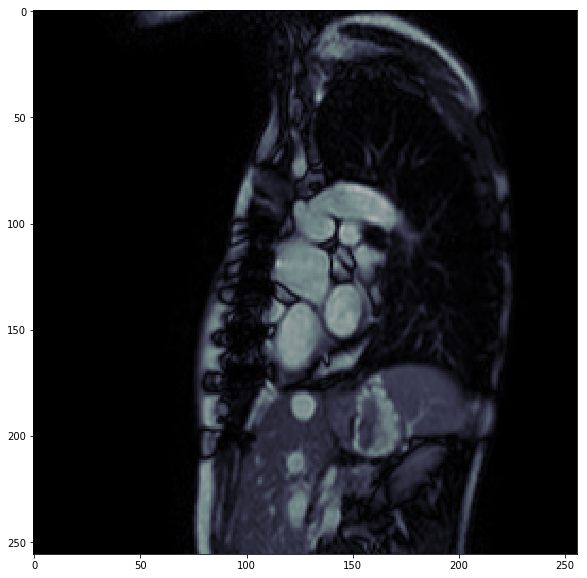

/Users/minority/Code/Git/cardio/src/visualization/visualize.py:70: RuntimeWarning: invalid value encountered in true_divide
  temp[...,0] = y_[...,0] # red


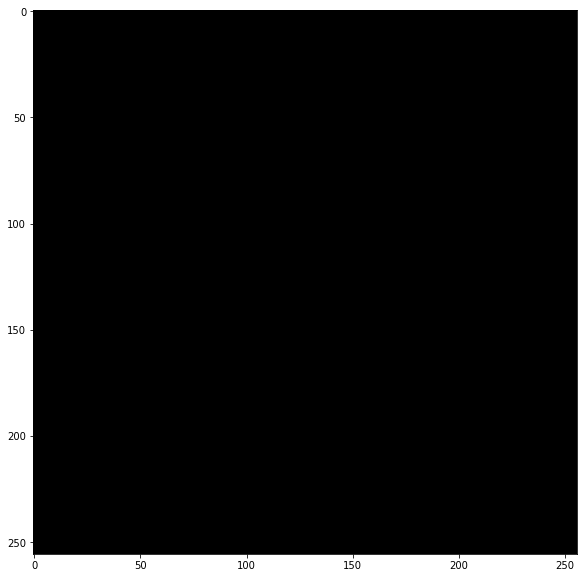

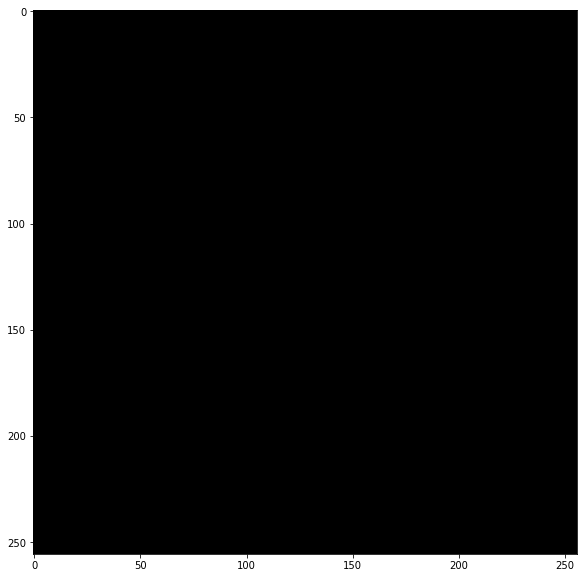

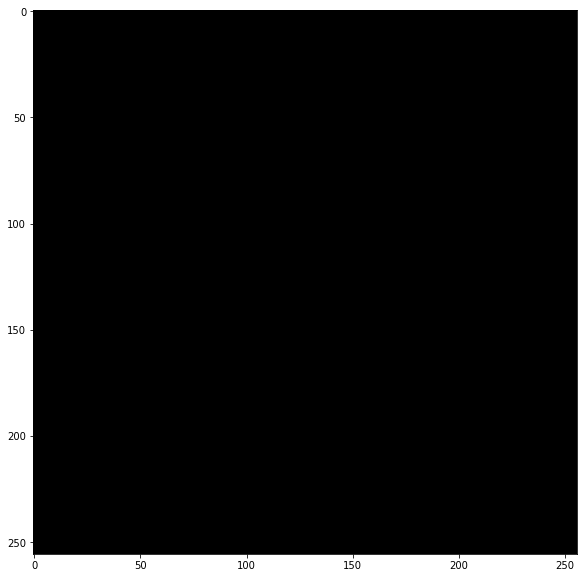

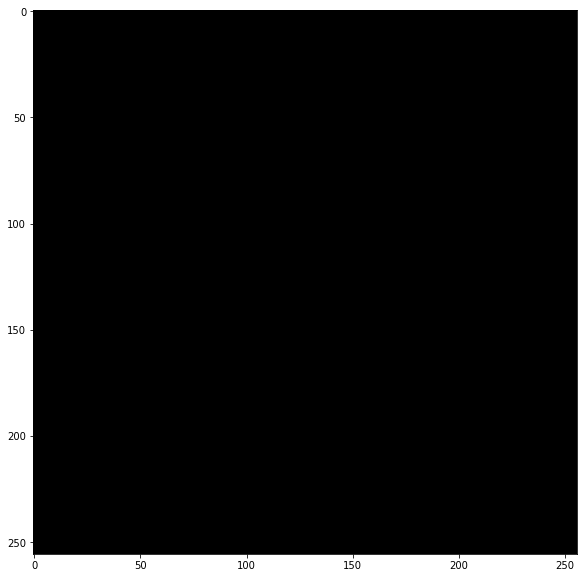

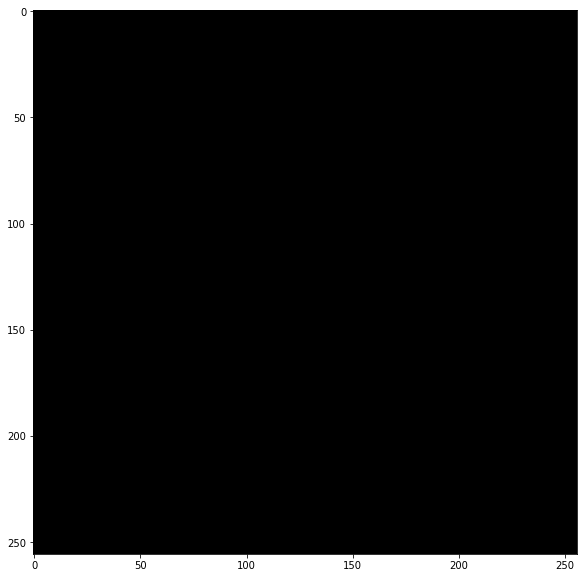

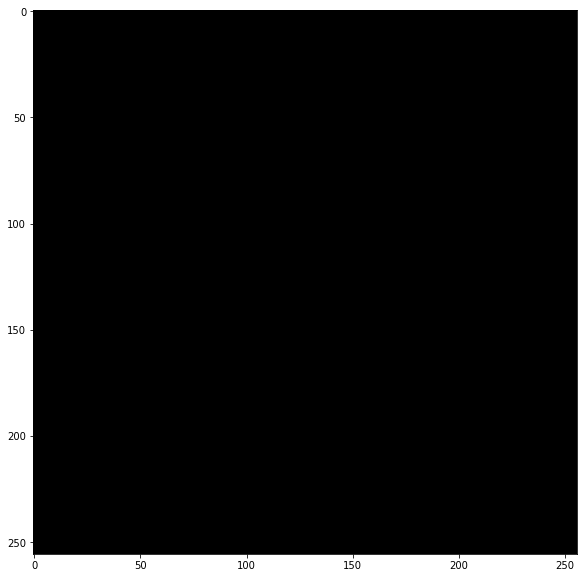

In [230]:

for s, m in zip(x[0], y[0]):
    plt.figure(figsize=(10,10))
    plt.imshow(show_slice(s, m, show=False))
    plt.show()
    
    plt.figure(figsize=(10,10))
    plt.imshow(s, 'bone')
    plt.imshow((m[...,1:]).astype(np.float32), interpolation='none', alpha=.3)
    plt.show()
    